# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Vikesh | Patel | Vikesh | 4 | 25% |
| Member 2: | First Name | Last Name | Signature | Hours | Contribution |
| Member 3: | First Name | Last Name | Signature | Hours | Contribution |
| Member 4: | First Name | Last Name | Signature | Hours | Contribution |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

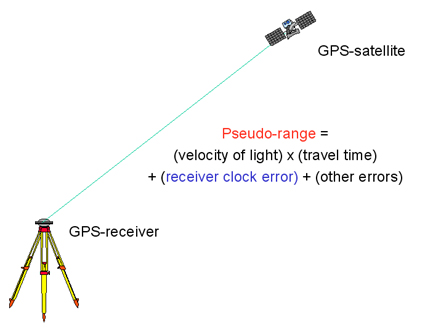

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [3]:
df_pseudorange = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3/pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3/satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [4]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [5]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [6]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    # changing the shape so that satellite pos array and reciever pos array become same size
    receiver_pos = np.reshape(receiver_pos, (1, -1))
    if satellite_pos.ndim == 1:  # If satellite_pos is 1D, make it 2D
        satellite_pos = np.reshape(satellite_pos, (1, -1))
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [7]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
    L = 0
    for i in range(len(s_pos)):
        predicted_pseudorange = euclidean_norm(r_pos, s_pos[i])[0] + cdT
        residual = pseudorange[i] - predicted_pseudorange
        L += residual ** 2
    return L

In [8]:
print(cost_function(GroundTruth, 0, sat_pos, pseudorange))

218.11293249462665


### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [9]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):
    grad = np.zeros(4)
    for i in range(len(s_pos)):
        predicted_pseudorange = euclidean_norm(r_pos, s_pos[i])[0] + cdT
        residual = pseudorange[i] - predicted_pseudorange
        distance = euclidean_norm(r_pos, s_pos[i])[0]

        if distance != 0:
            grad[:3] += -2 * residual * (r_pos - s_pos[i]) / distance
        grad[3] += -2 * residual
    return grad

In [10]:
print(gradient(GroundTruth, 0, sat_pos, pseudorange))

[ 12.33149924 -10.78111633  41.1025859  -87.79500721]


### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [11]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.1, max_iters=10000, tolerance=1e-6):

    global steps_count

    #initalize the estimates as zeros
    X = np.array([0,0,0,0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange)


        # update estimates
        # (1 mark)
        X_new = X - learning_rate * grad

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration
            break

        # update the parameters for the next iteration
        X = X_new

        #collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)

    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [14]:
optimized_params = gradient_descent(pseudorange, sat_pos)

# Calculate final position errors of receiver by comparing with ground truth
final_position_error = optimized_params[:3] - GroundTruth

# Calculate final cost value using the cost function
final_cost = cost_function(optimized_params[:3], optimized_params[3], sat_pos, pseudorange)

# Calculate final gradient values using the gradient function
final_gradient = gradient(optimized_params[:3], optimized_params[3], sat_pos, pseudorange)


# print the mentioned metrics
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params)
print("Final Position Errors of Receiver:", final_position_error)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost)
print("Final Gradient Values:", final_gradient)

<ipython-input-7-cd530501cc27>:7: RuntimeWarning: overflow encountered in scalar power
  L += residual ** 2
<ipython-input-9-27b7154754d2>:10: RuntimeWarning: overflow encountered in multiply
  grad[:3] += -2 * residual * (r_pos - s_pos[i]) / distance
<ipython-input-11-59c06d77a2f0>:31: RuntimeWarning: invalid value encountered in scalar subtract
  if np.abs(new_cost - current_cost) < tolerance:
<ipython-input-9-27b7154754d2>:10: RuntimeWarning: invalid value encountered in divide
  grad[:3] += -2 * residual * (r_pos - s_pos[i]) / distance


Optimized Parameters (x_r, y_r, z_r, cdT): [nan nan nan nan]
Final Position Errors of Receiver: [nan nan nan]
Number of Steps Taken for Convergence: 0
Final Cost Value: nan
Final Gradient Values: [nan nan nan nan]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

/usr/local/lib/python3.10/dist-packages/matplotlib/scale.py:255: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)


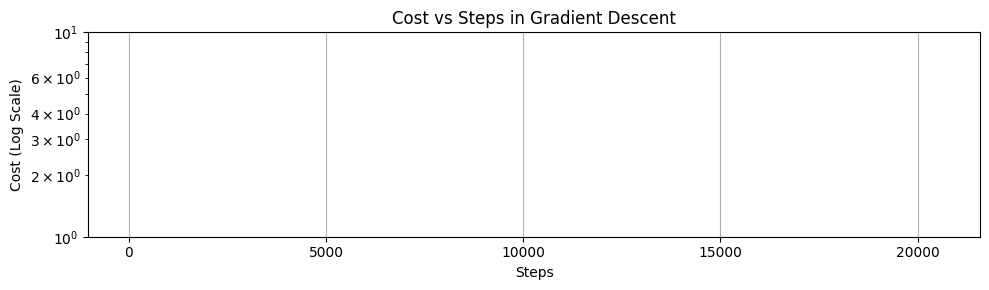

No pattern is seen due to overflow of finite and infinite values due to the bigger value of Learning rate


In [15]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
# Plot cost vs steps with logarithmic scaling on the y-axis
ax.semilogy(range(len(arr_cost)), arr_cost, label="Cost")

# Label the axes
ax.set_xlabel("Steps")
ax.set_ylabel("Cost (Log Scale)")

# Set title
ax.set_title("Cost vs Steps in Gradient Descent")

ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
print("No pattern is seen due to overflow of finite and infinite values due to the bigger value of Learning rate")

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

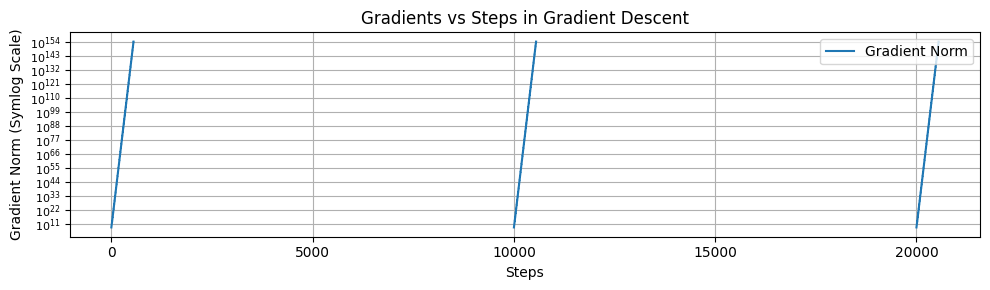

At steps 0, 10000, and 20000 Gradient norm begins at 10^11 but increase in few steps the Gradient norm increase drastically


In [19]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
gradient_norms = [np.linalg.norm(grad) for grad in arr_grad]
# Use symlog scaling on the y-axis to handle positive and negative gradients symmetrically
ax.plot(gradient_norms, label="Gradient Norm")
ax.set_yscale('symlog')

# Label each axis
ax.set_xlabel("Steps")
ax.set_ylabel("Gradient Norm (Symlog Scale)")

# Set title and legend
ax.set_title("Gradients vs Steps in Gradient Descent")
ax.legend()

# Set y-axis tick label size
ax.tick_params(axis='y', labelsize=8)

ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
print("At steps 0, 10000, and 20000 Gradient norm begins at 10^11 but increase in few steps the Gradient norm increase drastically")

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

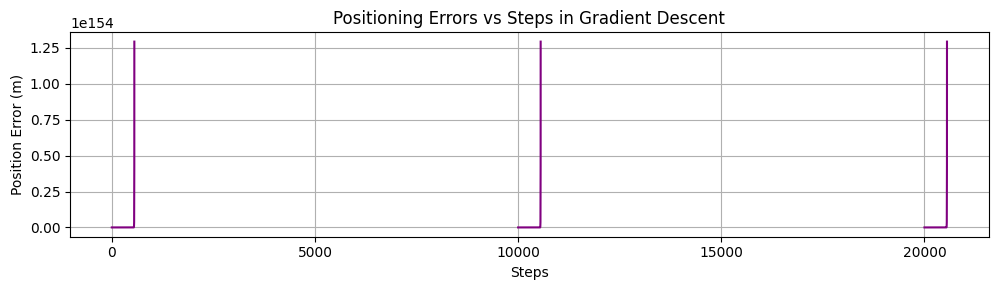

At initial state at 0, 10000, and 20000 the position error was zero while it increases to infinite at some point of steps after 0, 10000, and 20000


In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
position_errors = [np.linalg.norm(error) for error in arr_err]
# Plot position errors over steps
ax.plot(position_errors, label="Position Error Norm", color="purple")

# Label each axis
ax.set_xlabel("Steps")
ax.set_ylabel("Position Error (m)")
ax.set_title("Positioning Errors vs Steps in Gradient Descent")

ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
print("At initial state at 0, 10000, and 20000 the position error was zero while it increases to infinite at some point of steps after 0, 10000, and 20000")

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [20]:
#set learning rate to 0.01
learning_rate=0.01
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_2 = gradient_descent(pseudorange, sat_pos)

# Calculate final position errors of receiver by comparing with ground truth
final_position_error_2 = optimized_params_2[:3] - GroundTruth

# Calculate final cost value using the cost function
final_cost_2 = cost_function(optimized_params_2[:3], optimized_params_2[3], sat_pos, pseudorange)

# Calculate final gradient values using the gradient function
final_gradient_2 = gradient(optimized_params_2[:3], optimized_params_2[3], sat_pos, pseudorange)


# print the mentioned metrics
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params_2)
print("Final Position Errors of Receiver:", final_position_error_2)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost_2)
print("Final Gradient Values:", final_gradient_2)

<ipython-input-7-cd530501cc27>:7: RuntimeWarning: overflow encountered in scalar power
  L += residual ** 2
<ipython-input-9-27b7154754d2>:10: RuntimeWarning: overflow encountered in multiply
  grad[:3] += -2 * residual * (r_pos - s_pos[i]) / distance
<ipython-input-11-59c06d77a2f0>:31: RuntimeWarning: invalid value encountered in scalar subtract
  if np.abs(new_cost - current_cost) < tolerance:
<ipython-input-9-27b7154754d2>:10: RuntimeWarning: invalid value encountered in divide
  grad[:3] += -2 * residual * (r_pos - s_pos[i]) / distance


Optimized Parameters (x_r, y_r, z_r, cdT): [nan nan nan nan]
Final Position Errors of Receiver: [nan nan nan]
Number of Steps Taken for Convergence: 0
Final Cost Value: nan
Final Gradient Values: [nan nan nan nan]


In [21]:
#set learning rate to 0.001
learning_rate=0.001
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_3 = gradient_descent(pseudorange, sat_pos)

# Calculate final position errors of receiver by comparing with ground truth
final_position_error_3 = optimized_params_3[:3] - GroundTruth

# Calculate final cost value using the cost function
final_cost_3 = cost_function(optimized_params_3[:3], optimized_params_3[3], sat_pos, pseudorange)

# Calculate final gradient values using the gradient function
final_gradient_3 = gradient(optimized_params_3[:3], optimized_params_3[3], sat_pos, pseudorange)


# print the mentioned metrics
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params_3)
print("Final Position Errors of Receiver:", final_position_error_3)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost_3)
print("Final Gradient Values:", final_gradient_3)

<ipython-input-7-cd530501cc27>:7: RuntimeWarning: overflow encountered in scalar power
  L += residual ** 2
<ipython-input-9-27b7154754d2>:10: RuntimeWarning: overflow encountered in multiply
  grad[:3] += -2 * residual * (r_pos - s_pos[i]) / distance
<ipython-input-11-59c06d77a2f0>:31: RuntimeWarning: invalid value encountered in scalar subtract
  if np.abs(new_cost - current_cost) < tolerance:
<ipython-input-9-27b7154754d2>:10: RuntimeWarning: invalid value encountered in divide
  grad[:3] += -2 * residual * (r_pos - s_pos[i]) / distance


Optimized Parameters (x_r, y_r, z_r, cdT): [nan nan nan nan]
Final Position Errors of Receiver: [nan nan nan]
Number of Steps Taken for Convergence: 0
Final Cost Value: nan
Final Gradient Values: [nan nan nan nan]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE

In [22]:
# Comment on the difference that you notice after changing the learning rate. (1 mark)
print("Answer1: This changes the learning rate of the model significantly. A learning rate too high causes the system to overshoot the optimal solution, probably causing divergence,\n while a small learning rate can make convergence slow, taking more time in training.")

# What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)
print("Answer2: LSE has a closed-form solution while trying to minimize the error from linear regression, whereas the Gradient Descent is itself an iterative optimization algorithm, which updates parameters incrementally.\n LSE runs faster when the size of the dataset is modestly small, while Gradient Descent is really flexible and powerful in handling large-scale datasets or complex models.")

Answer1: This changes the learning rate of the model significantly. A learning rate too high causes the system to overshoot the optimal solution, probably causing divergence,
 while a small learning rate can make convergence slow, taking more time in training.
Answer2: LSE has a closed-form solution while trying to minimize the error from linear regression, whereas the Gradient Descent is itself an iterative optimization algorithm, which updates parameters incrementally.
 LSE runs faster when the size of the dataset is modestly small, while Gradient Descent is really flexible and powerful in handling large-scale datasets or complex models.


---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)

# TO DO: display sizes of X and y (1 mark)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

In [ ]:
# TO DO: Check the class distribution of y (2 mark)


# Display exact values for each bin in the histogram

plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [ ]:
# TO DO: Create a smaller dataset with 3% of the data


# TO DO: display sizes of X_small and y_small (2 mark)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [ ]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information



### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [ ]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set


In [ ]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat

# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')

In [ ]:
# TO DO: Print classification report (2 marks)


### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

---
---